In [126]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

pd.set_option('display.float_format', '{:.2f}'.format)

from load_data import load_data
from settings import config

# Get the data directory from the configuration
DATA_DIR = config("DATA_DIR")

In [146]:
# TICKERS = ["BTC-USD", "ETH-USD", "SOL-USD"]
TICKERS = ["BTC-USD"]
MA_DAYS = [28]
START_DATE = "2016-01-01"
END_DATE = "2025-06-30"

In [147]:
def load_crypto_data(
    tickers: list,
    base_directory,
    start_date: str,
    end_date: str,
) -> dict:
    """
    Loads minute-level data for multiple crypto tickers from Coinbase source.

    Parameters:
    - tickers: list of strings, e.g., ["BTC-USD", "ETH-USD", "SOL-USD"]
    - base_directory: path to your data directory (from config)
    - start_date: optional string, e.g., "2023-01-01"
    - end_date: optional string, e.g., "2023-12-31"

    Returns:
    - dict of DataFrames keyed by ticker
    """
    data = {}
    for ticker in tickers:
        df = load_data(
            base_directory=base_directory,
            ticker=ticker,
            source="Coinbase",
            asset_class="Cryptocurrencies",
            timeframe="Minute",
            file_format="pickle",
        )
        df.index = pd.to_datetime(df.index)
        df = df.sort_index()

        # Apply date filtering if specified
        if start_date:
            df = df[df.index >= pd.to_datetime(start_date)]
        if end_date:
            df = df[df.index <= pd.to_datetime(end_date)]

        data[ticker] = df

    return data


crypto_data = load_crypto_data(
    tickers=TICKERS,
    base_directory=DATA_DIR,
    start_date=START_DATE,
    end_date=END_DATE,
)

crypto_data

{'BTC-USD':                           low      high      open     close  volume
 Date                                                               
 2016-01-01 00:00:00    430.35    430.39    430.35    430.39    0.07
 2016-01-01 00:01:00    430.38    430.40    430.38    430.40    0.95
 2016-01-01 00:02:00    430.40    430.40    430.40    430.40    1.63
 2016-01-01 00:03:00    430.36    430.39    430.39    430.36   12.57
 2016-01-01 00:04:00    430.39    430.39    430.39    430.39    1.95
 ...                       ...       ...       ...       ...     ...
 2025-06-29 23:56:00 108394.63 108452.81 108436.49 108396.24    2.93
 2025-06-29 23:57:00 108396.23 108413.54 108396.24 108411.22    1.11
 2025-06-29 23:58:00 108386.34 108411.22 108411.21 108389.07    0.86
 2025-06-29 23:59:00 108386.41 108389.07 108389.07 108386.44    0.38
 2025-06-30 00:00:00 108341.37 108450.00 108386.44 108355.95    9.59
 
 [4894620 rows x 5 columns]}

In [148]:
def calculate_rsi(prices: pd.Series, period: int = 14) -> pd.Series:
    """Calculates the Relative Strength Index (RSI) for a price series."""
    delta = prices.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    avg_gain = gain.ewm(alpha=1/period, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/period, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [149]:
def prepare_crypto_indicators(
    data: dict,
    rsi_period: int = 14,
    ma_days: list = [7, 14, 21, 28, 35, 42, 49, 56, 63, 70]
) -> dict:
    """
    Adds RSI and daily moving averages to each crypto DataFrame.

    Parameters:
    - data: dict of DataFrames keyed by ticker
    - rsi_period: RSI lookback (default=14)
    - ma_days: list of MA durations (in days) for trend allocation

    Returns:
    - dict of enriched DataFrames with 'RSI' and MA columns
    """
    enriched_data = {}

    for ticker, df in data.items():
        df = df.copy()
        df["RSI"] = calculate_rsi(df["close"], period=rsi_period)

        for day in ma_days:
            window = 1440 * day  # 1440 minutes in a day
            df[f"MA_{day}d"] = df["close"].rolling(window=window, min_periods=1).mean()

        enriched_data[ticker] = df

    return enriched_data

enriched_data = prepare_crypto_indicators(
    data=crypto_data,
    rsi_period=14,
    ma_days=MA_DAYS,
)

enriched_data

{'BTC-USD':                           low      high      open     close  volume    RSI  \
 Date                                                                         
 2016-01-01 00:00:00    430.35    430.39    430.35    430.39    0.07    NaN   
 2016-01-01 00:01:00    430.38    430.40    430.38    430.40    0.95 100.00   
 2016-01-01 00:02:00    430.40    430.40    430.40    430.40    1.63 100.00   
 2016-01-01 00:03:00    430.36    430.39    430.39    430.36   12.57  75.11   
 2016-01-01 00:04:00    430.39    430.39    430.39    430.39    1.95  79.28   
 ...                       ...       ...       ...       ...     ...    ...   
 2025-06-29 23:56:00 108394.63 108452.81 108436.49 108396.24    2.93  53.21   
 2025-06-29 23:57:00 108396.23 108413.54 108396.24 108411.22    1.11  55.37   
 2025-06-29 23:58:00 108386.34 108411.22 108411.21 108389.07    0.86  51.57   
 2025-06-29 23:59:00 108386.41 108389.07 108389.07 108386.44    0.38  51.13   
 2025-06-30 00:00:00 108341.37 108450.00 

In [150]:
def backtest_rsi_multi_asset_strategy(
    data: dict,
    initial_capital: float,
    rsi_threshold: float,
    trailing_stop_pct: float,
    ma_days: list,
) -> pd.DataFrame:
    """
    Multi-asset backtest using RSI threshold + MA filter + trailing stop.
    
    Capital is shared across all assets. Each asset trades independently.

    Parameters:
    - data: dict of enriched DataFrames keyed by asset symbol (must have RSI and MA columns)
    - initial_capital: starting cash
    - rsi_threshold: RSI entry trigger (e.g., 30)
    - trailing_stop_pct: trailing stop trigger (e.g., 0.02)
    - ma_days: list of moving average day lengths

    Returns:
    - DataFrame of all trades across assets
    """
    # Merge index across all assets
    all_timestamps = sorted(set().union(*[df.index for df in data.values()]))
    
    # Initialize tracking variables
    cash = initial_capital
    trades = []
    positions = {symbol: None for symbol in data}
    
    # Prep asset DataFrames
    for df in data.values():
        df.sort_index(inplace=True)

    for timestamp in all_timestamps:
        for symbol, df in data.items():
            if timestamp not in df.index:
                continue

            row = df.loc[timestamp]

            # Current position state
            position = positions[symbol]

            # --- ENTRY ---
            if position is None:
                # Need previous RSI point to trigger
                i = df.index.get_loc(timestamp)
                if i == 0:
                    continue
                prev_rsi = df.iloc[i - 1]["RSI"]

                if prev_rsi < rsi_threshold:
                    ma_passes = sum(row["close"] > row[f"MA_{day}d"] for day in ma_days)
                    allocation_pct = ma_passes * (1 / len(ma_days))
                    if allocation_pct == 0:
                        continue

                    capital_to_use = cash * allocation_pct
                    entry_price = row["open"]
                    quantity = capital_to_use / entry_price

                    positions[symbol] = {
                        "entry_time": timestamp,
                        "entry_price": entry_price,
                        "peak_price": entry_price,
                        "quantity": quantity,
                        "allocation_pct": allocation_pct,
                    }

                    cash -= quantity * entry_price

            # --- EXIT ---
            elif position is not None:
                peak_price = max(position["peak_price"], row["high"])
                stop_price = peak_price * (1 - trailing_stop_pct)

                if row["low"] <= stop_price:
                    exit_price = stop_price
                    quantity = position["quantity"]
                    pnl = quantity * (exit_price - position["entry_price"])
                    return_pct = (exit_price - position["entry_price"]) / position["entry_price"]

                    cash += quantity * exit_price

                    trades.append({
                        "asset": symbol,
                        "entry_time": position["entry_time"],
                        "exit_time": timestamp,
                        "entry_price": position["entry_price"],
                        "exit_price": exit_price,
                        "quantity": quantity,
                        "allocation_pct": position["allocation_pct"],
                        "pnl": pnl,
                        "return_pct": return_pct * 100,
                        "cash": cash,
                    })

                    positions[symbol] = None
                else:
                    positions[symbol]["peak_price"] = peak_price

    trades_df = pd.DataFrame(trades)
    if not trades_df.empty:
        trades_df["cumulative_pnl"] = trades_df["pnl"].cumsum()
        trades_df["equity"] = trades_df["cumulative_pnl"] + initial_capital
        trades_df["cumulative_return"] = trades_df["equity"] / initial_capital - 1

    # Export trades DataFrame
    trades_df.to_csv("multi_asset_trades.csv", index=False)

    return trades_df

trades_df = backtest_rsi_multi_asset_strategy(
    data=enriched_data,
    initial_capital=100_000,
    rsi_threshold=30,
    trailing_stop_pct=0.02,
    ma_days=MA_DAYS,
)

trades_df

,asset,entry_time,exit_time,entry_price,exit_price,quantity,allocation_pct,pnl,return_pct,cash,cumulative_pnl,equity,cumulative_return
0,BTC-USD,2016-01-01 06:03:00,2016-01-03 13:45:00,435.63,428.81,229.55,1.00,-1565.82,-1.57,98434.18,-1565.82,98434.18,-0.02
1,BTC-USD,2016-01-04 08:45:00,2016-01-08 07:16:00,434.04,455.11,226.79,1.00,4778.83,4.85,103213.01,3213.01,103213.01,0.03
2,BTC-USD,2016-01-08 07:17:00,2016-01-08 18:06:00,455.10,449.43,226.79,1.00,-1286.36,-1.25,101926.65,1926.65,101926.65,0.02
3,BTC-USD,2016-01-08 18:07:00,2016-01-10 00:53:00,448.51,446.88,227.26,1.00,-370.43,-0.36,101556.22,1556.22,101556.22,0.02
4,BTC-USD,2016-01-10 00:54:00,2016-01-12 23:50:00,445.69,443.60,227.86,1.00,-476.92,-0.47,101079.30,1079.30,101079.30,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4492,BTC-USD,2025-06-10 15:34:00,2025-06-11 22:24:00,108406.83,108226.35,1178.35,1.00,-212669.84,-0.17,127528553.00,127428553.00,127528553.00,1274.29
4493,BTC-USD,2025-06-11 22:25:00,2025-06-12 13:32:00,108266.91,106676.67,1177.91,1.00,-1873163.45,-1.47,125655389.55,125555389.55,125655389.55,1255.55
4494,BTC-USD,2025-06-12 13:33:00,2025-06-12 20:40:00,106591.82,106309.05,1178.85,1.00,-333345.24,-0.27,125322044.31,125222044.31,125322044.31,1252.22
4495,BTC-USD,2025-06-16 10:42:00,2025-06-16 23:57:00,106983.74,106820.00,1171.41,1.00,-191807.01,-0.15,125130237.30,125030237.30,125130237.30,1250.30


In [151]:
# Filter the entry trades
entry_trades_df = trades_df.copy()
entry_trades_df = entry_trades_df[['asset', 'entry_time', 'entry_price', 'quantity']]
entry_trades_df['cash'] = entry_trades_df['entry_price'] * entry_trades_df['quantity'] * -1
entry_trades_df['crypto_value'] = entry_trades_df['quantity'] * entry_trades_df['entry_price']
entry_trades_df.rename(columns={'entry_time': 'Date'}, inplace=True)

entry_trades_df

,asset,Date,entry_price,quantity,cash,crypto_value
0,BTC-USD,2016-01-01 06:03:00,435.63,229.55,-100000.00,100000.00
1,BTC-USD,2016-01-04 08:45:00,434.04,226.79,-98434.18,98434.18
2,BTC-USD,2016-01-08 07:17:00,455.10,226.79,-103213.01,103213.01
3,BTC-USD,2016-01-08 18:07:00,448.51,227.26,-101926.65,101926.65
4,BTC-USD,2016-01-10 00:54:00,445.69,227.86,-101556.22,101556.22
...,...,...,...,...,...,...
4492,BTC-USD,2025-06-10 15:34:00,108406.83,1178.35,-127741222.84,127741222.84
4493,BTC-USD,2025-06-11 22:25:00,108266.91,1177.91,-127528553.00,127528553.00
4494,BTC-USD,2025-06-12 13:33:00,106591.82,1178.85,-125655389.55,125655389.55
4495,BTC-USD,2025-06-16 10:42:00,106983.74,1171.41,-125322044.31,125322044.31


In [152]:
# Filter the exit trades
exit_trades_df = trades_df.copy()
exit_trades_df = exit_trades_df[['asset', 'exit_time', 'exit_price', 'quantity']]
exit_trades_df['cash'] = exit_trades_df['exit_price'] * exit_trades_df['quantity']
exit_trades_df['quantity'] = exit_trades_df['quantity'] * -1  # Convert quantity to negative for exit
exit_trades_df['crypto_value'] = exit_trades_df['quantity'] * exit_trades_df['exit_price']
exit_trades_df.rename(columns={'exit_time': 'Date'}, inplace=True)

exit_trades_df

,asset,Date,exit_price,quantity,cash,crypto_value
0,BTC-USD,2016-01-03 13:45:00,428.81,-229.55,98434.18,-98434.18
1,BTC-USD,2016-01-08 07:16:00,455.11,-226.79,103213.01,-103213.01
2,BTC-USD,2016-01-08 18:06:00,449.43,-226.79,101926.65,-101926.65
3,BTC-USD,2016-01-10 00:53:00,446.88,-227.26,101556.22,-101556.22
4,BTC-USD,2016-01-12 23:50:00,443.60,-227.86,101079.30,-101079.30
...,...,...,...,...,...,...
4492,BTC-USD,2025-06-11 22:24:00,108226.35,-1178.35,127528553.00,-127528553.00
4493,BTC-USD,2025-06-12 13:32:00,106676.67,-1177.91,125655389.55,-125655389.55
4494,BTC-USD,2025-06-12 20:40:00,106309.05,-1178.85,125322044.31,-125322044.31
4495,BTC-USD,2025-06-16 23:57:00,106820.00,-1171.41,125130237.30,-125130237.30


In [153]:
# Combine entry and exit trades into a single DataFrame
ledger_events_df = pd.concat([entry_trades_df, exit_trades_df], ignore_index=True)
ledger_events_df = ledger_events_df.sort_values('Date')

ledger_events_df

,asset,Date,entry_price,quantity,cash,crypto_value,exit_price
0,BTC-USD,2016-01-01 06:03:00,435.63,229.55,-100000.00,100000.00,NaN
4497,BTC-USD,2016-01-03 13:45:00,NaN,-229.55,98434.18,-98434.18,428.81
1,BTC-USD,2016-01-04 08:45:00,434.04,226.79,-98434.18,98434.18,NaN
4498,BTC-USD,2016-01-08 07:16:00,NaN,-226.79,103213.01,-103213.01,455.11
2,BTC-USD,2016-01-08 07:17:00,455.10,226.79,-103213.01,103213.01,NaN
...,...,...,...,...,...,...,...
8991,BTC-USD,2025-06-12 20:40:00,NaN,-1178.85,125322044.31,-125322044.31,106309.05
4495,BTC-USD,2025-06-16 10:42:00,106983.74,1171.41,-125322044.31,125322044.31,NaN
8992,BTC-USD,2025-06-16 23:57:00,NaN,-1171.41,125130237.30,-125130237.30,106820.00
4496,BTC-USD,2025-06-16 23:59:00,106757.52,1172.10,-125130237.30,125130237.30,NaN


In [154]:
# Create pivot table for quantity
quantity_df = ledger_events_df.pivot_table(
    index='Date',
    columns='asset',
    values='quantity',
    aggfunc='sum',
).fillna(0)

quantity_df.columns = [f"{col}_qty" for col in quantity_df.columns]

# Cash flow dataframe
cash_df = ledger_events_df.groupby('Date')['cash'].sum().to_frame()

# Combine quantity and cash dataframes into the ledger
ledger_qtys_df = pd.concat([quantity_df, cash_df], axis=1).fillna(0)
ledger_qtys_df = ledger_qtys_df.sort_index()

ledger_qtys_df

,BTC-USD_qty,cash
Date,,
2016-01-01 06:03:00,229.55,-100000.00
2016-01-03 13:45:00,-229.55,98434.18
2016-01-04 08:45:00,226.79,-98434.18
2016-01-08 07:16:00,-226.79,103213.01
2016-01-08 07:17:00,226.79,-103213.01
...,...,...
2025-06-12 20:40:00,-1178.85,125322044.31
2025-06-16 10:42:00,1171.41,-125322044.31
2025-06-16 23:57:00,-1171.41,125130237.30


In [155]:
# Step 1: Extract end-of-day close prices for each asset
daily_prices = []

for ticker, df in crypto_data.items():
    # daily_close = df["close"].resample("D").last().to_frame(name=f"{ticker}_price")
    daily_close = df["close"].to_frame(name=f"{ticker}_close")
    daily_prices.append(daily_close)

# Step 2: Merge all daily prices into a single DataFrame
price_df = pd.concat(daily_prices, axis=1)

price_df

,BTC-USD_close
Date,
2016-01-01 00:00:00,430.39
2016-01-01 00:01:00,430.40
2016-01-01 00:02:00,430.40
2016-01-01 00:03:00,430.36
2016-01-01 00:04:00,430.39
...,...
2025-06-29 23:56:00,108396.24
2025-06-29 23:57:00,108411.22
2025-06-29 23:58:00,108389.07


In [156]:
# Merge close prices into the ledger
ledger_qtys_prices_df = ledger_qtys_df.merge(price_df, left_index=True, right_index=True, how="outer")
ledger_qtys_prices_df.reset_index(inplace=True)
ledger_qtys_prices_df.rename(columns={'index': 'Date'}, inplace=True)

# Replace all NaN values with 0
ledger_qtys_prices_df.fillna(0, inplace=True)

# Add columns for each asset's cumulative quantity
quantity_cols = [col for col in ledger_qtys_prices_df.columns if col.endswith("_qty")]
for col in quantity_cols:
    ledger_qtys_prices_df[col] = ledger_qtys_prices_df[col].cumsum()

# Cumulative cash column
ledger_qtys_prices_df['cash'] = ledger_qtys_prices_df['cash'].cumsum()

# Add 100,000 to cash to represent initial capital
ledger_qtys_prices_df['cash'] += 100_000

# Establish position columns for each asset
ledger_qtys_prices_pos_df = ledger_qtys_prices_df.copy()
for col in quantity_cols:
    asset_name = col.replace("_qty", "")
    ledger_qtys_prices_pos_df[f"{asset_name}_position"] = ledger_qtys_prices_pos_df[col] * ledger_qtys_prices_pos_df[f"{asset_name}_close"]

# Re-arrange the columns to have cash first, then quantities, prices, positions grouped by asset
cols = ['Date', 'cash'] + [col for col in ledger_qtys_prices_pos_df.columns if col.startswith('BTC')] + [col for col in ledger_qtys_prices_pos_df.columns if col.startswith('ETH')] + [col for col in ledger_qtys_prices_pos_df.columns if col.startswith('SOL')]
ledger_qtys_prices_pos_df = ledger_qtys_prices_pos_df[cols]

# Calculate total portfolio value
ledger_qtys_prices_pos_df['equity'] = ledger_qtys_prices_pos_df['cash'] + ledger_qtys_prices_pos_df[[col for col in ledger_qtys_prices_pos_df.columns if col.endswith('_position')]].sum(axis=1)

ledger_qtys_prices_pos_df

,Date,cash,BTC-USD_qty,BTC-USD_close,BTC-USD_position,equity
0,2016-01-01 00:00:00,100000.00,0.00,430.39,0.00,100000.00
1,2016-01-01 00:01:00,100000.00,0.00,430.40,0.00,100000.00
2,2016-01-01 00:02:00,100000.00,0.00,430.40,0.00,100000.00
3,2016-01-01 00:03:00,100000.00,0.00,430.36,0.00,100000.00
4,2016-01-01 00:04:00,100000.00,0.00,430.39,0.00,100000.00
...,...,...,...,...,...,...
4894615,2025-06-29 23:56:00,123816927.68,0.00,108396.24,0.00,123816927.68
4894616,2025-06-29 23:57:00,123816927.68,0.00,108411.22,0.00,123816927.68
4894617,2025-06-29 23:58:00,123816927.68,0.00,108389.07,0.00,123816927.68
4894618,2025-06-29 23:59:00,123816927.68,0.00,108386.44,0.00,123816927.68


In [157]:
# Set the 'Date' column as the index
ledger_qtys_prices_pos_df = ledger_qtys_prices_pos_df.set_index('Date')

# Step 3: Reindex ledger to daily frequency (if not already)
daily_ledger_qtys_prices_pos_df = ledger_qtys_prices_pos_df.copy()
daily_ledger_qtys_prices_pos_df = daily_ledger_qtys_prices_pos_df.resample("D").last()

daily_ledger_qtys_prices_pos_df

,cash,BTC-USD_qty,BTC-USD_close,BTC-USD_position,equity
Date,,,,,
2016-01-01,0.00,229.55,435.66,100006.89,100006.89
2016-01-02,0.00,229.55,435.40,99947.20,99947.20
2016-01-03,98434.18,0.00,431.91,0.00,98434.18
2016-01-04,0.00,226.79,433.85,98391.09,98391.09
2016-01-05,0.00,226.79,433.34,98275.43,98275.43
...,...,...,...,...,...
2025-06-26,123816927.68,0.00,107029.64,0.00,123816927.68
2025-06-27,123816927.68,0.00,107113.38,0.00,123816927.68
2025-06-28,123816927.68,0.00,107352.20,0.00,123816927.68


In [158]:
# Drop the columns where any of the crypto asset prices = 0
price_cols = [col for col in daily_ledger_qtys_prices_pos_df.columns if col.endswith("_close")]
complete_ledger = daily_ledger_qtys_prices_pos_df[~(daily_ledger_qtys_prices_pos_df[price_cols] == 0).any(axis=1)]

complete_ledger

,cash,BTC-USD_qty,BTC-USD_close,BTC-USD_position,equity
Date,,,,,
2016-01-01,0.00,229.55,435.66,100006.89,100006.89
2016-01-02,0.00,229.55,435.40,99947.20,99947.20
2016-01-03,98434.18,0.00,431.91,0.00,98434.18
2016-01-04,0.00,226.79,433.85,98391.09,98391.09
2016-01-05,0.00,226.79,433.34,98275.43,98275.43
...,...,...,...,...,...
2025-06-26,123816927.68,0.00,107029.64,0.00,123816927.68
2025-06-27,123816927.68,0.00,107113.38,0.00,123816927.68
2025-06-28,123816927.68,0.00,107352.20,0.00,123816927.68


In [159]:
# Calculate crypto daily return, cumulative return, and drawdown
qty_cols = [col for col in complete_ledger.columns if col.endswith("_qty")]
# asset_symbols = [col.replace("_qty", "") for col in qty_cols]
# for col in asset_symbols:
for col in TICKERS:
    complete_ledger[f"{col}_return"] = complete_ledger[f"{col}_close"].pct_change()
    complete_ledger[f"{col}_cum_return"] = (1 + complete_ledger[f"{col}_return"]).cumprod() - 1
    complete_ledger[f"{col}_drawdown"] = (complete_ledger[f"{col}_close"] - complete_ledger[f"{col}_close"].cummax()) / complete_ledger[f"{col}_close"].cummax()

# Calculate portfolio daily return and cumulative return
complete_ledger['Return'] = complete_ledger['equity'].pct_change()
complete_ledger['Cum_Return'] = (1 + complete_ledger['Return']).cumprod() - 1

# Calculate drawdown
complete_ledger["Drawdown"] = (complete_ledger["equity"] - complete_ledger["equity"].cummax()) / complete_ledger["equity"].cummax()

complete_ledger

/tmp/ipykernel_4157/1910673151.py:6: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  complete_ledger[f"{col}_return"] = complete_ledger[f"{col}_close"].pct_change()
/tmp/ipykernel_4157/1910673151.py:11: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  complete_ledger['Return'] = complete_ledger['equity'].pct_change()


,cash,BTC-USD_qty,BTC-USD_close,BTC-USD_position,equity,BTC-USD_return,BTC-USD_cum_return,BTC-USD_drawdown,Return,Cum_Return,Drawdown
Date,,,,,,,,,,,
2016-01-01,0.00,229.55,435.66,100006.89,100006.89,NaN,NaN,0.00,NaN,NaN,0.00
2016-01-02,0.00,229.55,435.40,99947.20,99947.20,-0.00,-0.00,-0.00,-0.00,-0.00,-0.00
2016-01-03,98434.18,0.00,431.91,0.00,98434.18,-0.01,-0.01,-0.01,-0.02,-0.02,-0.02
2016-01-04,0.00,226.79,433.85,98391.09,98391.09,0.00,-0.00,-0.00,-0.00,-0.02,-0.02
2016-01-05,0.00,226.79,433.34,98275.43,98275.43,-0.00,-0.01,-0.01,-0.00,-0.02,-0.02
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-26,123816927.68,0.00,107029.64,0.00,123816927.68,-0.00,244.67,-0.04,0.00,1237.08,-0.09
2025-06-27,123816927.68,0.00,107113.38,0.00,123816927.68,0.00,244.86,-0.04,0.00,1237.08,-0.09
2025-06-28,123816927.68,0.00,107352.20,0.00,123816927.68,0.00,245.41,-0.04,0.00,1237.08,-0.09


In [160]:
perf_df = complete_ledger
data = enriched_data
title = "Multi-Asset Strategy: Crypto RSI < 30 + MA Filter + 2% Trailing Stop + Dynamic BTC, ETH, and SOL Allocation"

/tmp/ipykernel_4157/704245085.py:111: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/home/jared/python-virtual-envs/general_313/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


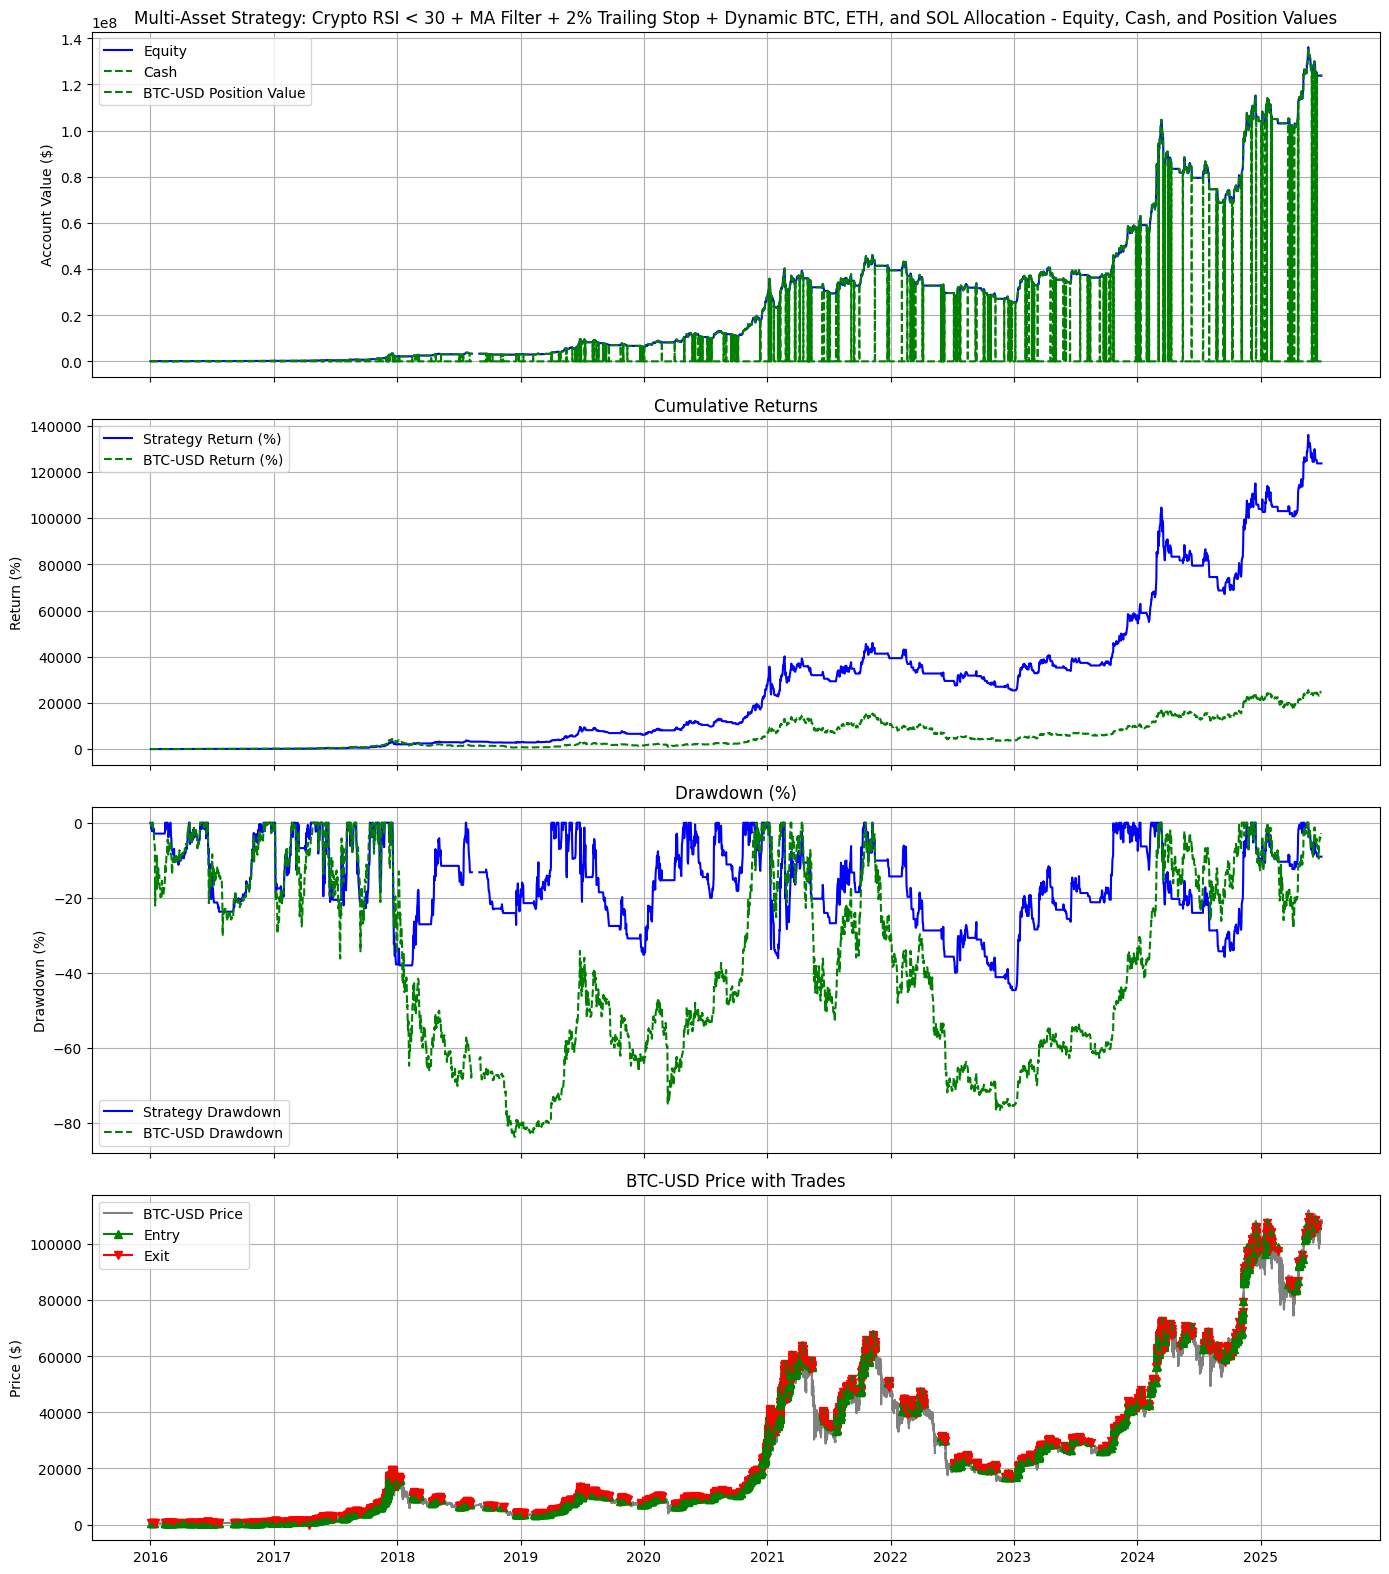

In [161]:
# def plot_multi_asset_equity_and_drawdown(
#     perf_df: pd.DataFrame,
#     trades: pd.DataFrame,
#     data: dict,
#     title: str = "Multi-Asset Strategy Performance"
# ) -> None:
"""
Plots:
- Total equity, cash, and per-asset position values
- Cumulative returns (strategy and crypto assets)
- Drawdowns (strategy and crypto assets)
- Price series and trade markers for BTC, ETH, SOL
"""

perf_df = perf_df.copy()
trades = trades_df.copy()
data = enriched_data

# Identify asset symbols
qty_cols = [col for col in perf_df.columns if col.endswith("_qty")]
asset_symbols = [col.replace("_qty", "") for col in qty_cols]

# # Compute position values and crypto drawdowns
colors = ["green", "red", "purple", "orange", "yellow"]

# # Setup plot
# fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(
#     6, 1, figsize=(14, 16), sharex=True, gridspec_kw={"height_ratios": [1, 1, 1, 1, 1, 1]}
# )

# Determine number of subplots
n_fixed = 3  # ax1, ax2, ax3
n_tickers = len(TICKERS)
total_axes = n_fixed + n_tickers

# Setup plot
fig, axes = plt.subplots(
    total_axes, 1,
    figsize=(14, 4 * total_axes),
    sharex=True,
    gridspec_kw={"height_ratios": [1] * total_axes}
)

# Unpack fixed axes
ax1, ax2, ax3 = axes[:3]

# Assign price axes
price_axes = axes[3:]

# ax1: Equity, Cash, and Position Values
ax1.plot(perf_df.index, perf_df["equity"], color="blue", label="Equity")
ax1.plot(perf_df.index, perf_df["cash"], color="green", linestyle="--", label="Cash")
# for i, symbol in enumerate(asset_symbols):
for i, symbol in enumerate(TICKERS):
    ax1.plot(perf_df.index, perf_df[f"{symbol}_position"], linestyle="--", color=colors[i % len(colors)], label=f"{symbol} Position Value")
ax1.set_title(f"{title} - Equity, Cash, and Position Values")
ax1.set_ylabel("Account Value ($)")
ax1.legend()
ax1.grid(True)

# ax2: Cumulative Returns
ax2.plot(perf_df.index, perf_df["Cum_Return"] * 100, color="blue", label="Strategy Return (%)")
# for i, symbol in enumerate(asset_symbols):
for i, symbol in enumerate(TICKERS):
    ax2.plot(perf_df.index, perf_df[f"{symbol}_cum_return"] * 100, linestyle="--", color=colors[i % len(colors)], label=f"{symbol} Return (%)")
ax2.set_title("Cumulative Returns")
ax2.set_ylabel("Return (%)")
ax2.legend()
ax2.grid(True)

# ax3: Drawdowns
ax3.plot(perf_df.index, perf_df["Drawdown"] * 100, color="blue", label="Strategy Drawdown")
# for i, symbol in enumerate(asset_symbols):
for i, symbol in enumerate(TICKERS):
    ax3.plot(perf_df.index, perf_df[f"{symbol}_drawdown"] * 100, linestyle="--", color=colors[i % len(colors)], label=f"{symbol} Drawdown")
ax3.set_title("Drawdown (%)")
ax3.set_ylabel("Drawdown (%)")
ax3.legend()
ax3.grid(True)

# ax4, ax5, ax6... : Price plots with trade markers are dynamically created based on the number of crypto assets
for i, symbol in enumerate(TICKERS):
    df = data[symbol].copy()
    df.index = pd.to_datetime(df.index)
    plot_df = df[df.index >= trades["entry_time"].min()]
    ax = price_axes[i]
    ax.plot(plot_df.index, plot_df["close"], color="gray", label=f"{symbol} Price")

    # Mark trades
    asset_trades = trades[trades["asset"] == symbol]
    for _, trade in asset_trades.iterrows():
        if trade['quantity'] > 0:
            entry_time = trade["entry_time"]
            exit_time = trade["exit_time"]
            if entry_time in plot_df.index:
                ax.plot(entry_time, plot_df.loc[entry_time, "close"], marker="^", color="green", label="Entry" if "Entry" not in ax.get_legend_handles_labels()[1] else "")
            if exit_time in plot_df.index:
                ax.plot(exit_time, plot_df.loc[exit_time, "close"], marker="v", color="red", label="Exit" if "Exit" not in ax.get_legend_handles_labels()[1] else "")
        else:
            entry_time = trade["entry_time"]
            exit_time = trade["exit_time"]
            if entry_time in plot_df.index:
                ax.plot(entry_time, plot_df.loc[entry_time, "close"], marker="^", color="lightgreen", label="Entry (No trade due to position conflict)" if "Entry (No trade due to position conflict)" not in ax.get_legend_handles_labels()[1] else "")
            if exit_time in plot_df.index:
                ax.plot(exit_time, plot_df.loc[exit_time, "close"], marker="v", color="pink", label="Exit (No trade due to position conflict)" if "Exit (No trade due to position conflict)" not in ax.get_legend_handles_labels()[1] else "")
    ax.set_title(f"{symbol} Price with Trades")
    ax.set_ylabel("Price ($)")
    ax.legend()
    ax.grid(True)

plt.tight_layout()
plt.show()



In [162]:
filtered_trades = trades_df[trades_df['quantity'] > 0.01]

total_trades = len(filtered_trades)
print("\nTotal Trades:", total_trades)

win_rate = len(filtered_trades[filtered_trades['return_pct'] > 0]) / len(filtered_trades) * 100
print(f"Win Rate: {win_rate:.2f}%")

total_return = complete_ledger['Cum_Return'].iloc[-1] * 100
print(f"Total Return: {total_return:.2f}%" )

average_return_per_trade = filtered_trades['return_pct'].mean()
print(f"Average Return Per Trade: {average_return_per_trade:.2f}%")

max_trade_gain_return = filtered_trades['return_pct'].max()
print(f"Max Trade Gain (%): {max_trade_gain_return:.2f}%")

max_trade_loss_return = filtered_trades['return_pct'].min()
print(f"Max Trade Loss (%): {max_trade_loss_return:.2f}%")

total_pnl = filtered_trades['pnl'].sum()
print(f"Total PnL: ${total_pnl:,.2f}")

average_pnl_per_trade = filtered_trades['pnl'].mean()
print(f"Average PnL Per Trade: ${average_pnl_per_trade:,.2f}")

max_trade_gain_pnl = filtered_trades['pnl'].max()
print(f"Max Trade Gain ($): ${max_trade_gain_pnl:,.2f}")

max_trade_loss_pnl = filtered_trades['pnl'].min()
print(f"Max Trade Loss ($): ${max_trade_loss_pnl:,.2f}")

max_drawdown = complete_ledger['Drawdown'].min() * 100
print(f"Max Drawdown: {max_drawdown:.2f}%")


Total Trades: 4497
Win Rate: 39.20%
Total Return: 123708.40%
Average Return Per Trade: 0.18%
Max Trade Gain (%): 14.96%
Max Trade Loss (%): -2.00%
Total PnL: $123,716,927.68
Average PnL Per Trade: $27,510.99
Max Trade Gain ($): $10,830,726.94
Max Trade Loss ($): $-2,431,420.17
Max Drawdown: -44.66%


In [163]:
filtered_trades.sort_values(by=['return_pct'], ascending=False)

,asset,entry_time,exit_time,entry_price,exit_price,quantity,allocation_pct,pnl,return_pct,cash,cumulative_pnl,equity,cumulative_return
968,BTC-USD,2017-10-05 04:08:00,2017-10-09 20:04:00,4155.96,4777.88,158.07,1.00,98308.97,14.96,755253.10,655253.10,755253.10,6.55
797,BTC-USD,2017-08-02 21:08:00,2017-08-05 03:17:00,2655.01,3027.10,171.16,1.00,63688.11,14.01,518125.15,418125.15,518125.15,4.18
636,BTC-USD,2017-06-04 20:02:00,2017-06-06 03:17:00,2474.11,2815.80,190.91,1.00,65231.49,13.81,537553.51,437553.51,537553.51,4.38
2565,BTC-USD,2020-10-16 04:08:00,2020-10-21 23:02:00,11410.94,12985.04,1011.81,1.00,1592682.82,13.79,13138338.97,13038338.97,13138338.97,130.38
3934,BTC-USD,2023-06-19 18:55:00,2023-06-21 16:57:00,26566.68,30184.00,1283.60,1.00,4643205.47,13.62,38744295.17,38644295.17,38744295.17,386.44
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2384,BTC-USD,2020-05-04 01:15:00,2020-05-04 05:13:00,8792.11,8616.27,1182.55,1.00,-207941.82,-2.00,10189149.22,10089149.22,10189149.22,100.89
346,BTC-USD,2017-02-24 11:19:00,2017-02-24 11:25:00,1168.00,1144.64,215.00,1.00,-5022.29,-2.00,246092.20,146092.20,246092.20,1.46
2907,BTC-USD,2021-01-12 10:10:00,2021-01-12 10:29:00,35560.75,34849.53,695.17,1.00,-494415.54,-2.00,24226361.49,24126361.49,24226361.49,241.26
572,BTC-USD,2017-05-27 06:06:00,2017-05-27 06:17:00,2100.95,2058.93,193.08,1.00,-8113.06,-2.00,397539.77,297539.77,397539.77,2.98


In [164]:
for ticker in TICKERS:
    print(f"Trade analysis for {ticker}:")
    trades_by_ticker = filtered_trades[filtered_trades['asset'] == ticker]

    total_trades = len(trades_by_ticker)
    print("\nTotal Trades:", total_trades)

    win_rate = len(trades_by_ticker[trades_by_ticker['return_pct'] > 0]) / len(trades_by_ticker) * 100
    print(f"Win Rate: {win_rate:.2f}%")

    average_return_per_trade = trades_by_ticker['return_pct'].mean()
    print(f"Average Return Per Trade: {average_return_per_trade:.2f}%")

    max_trade_gain_return = trades_by_ticker['return_pct'].max()
    print(f"Max Trade Gain (%): {max_trade_gain_return:.2f}%")

    max_trade_loss_return = trades_by_ticker['return_pct'].min()
    print(f"Max Trade Loss (%): {max_trade_loss_return:.2f}%")

    total_pnl = trades_by_ticker['pnl'].sum()
    print(f"Total PnL: ${total_pnl:,.2f}")

    average_pnl_per_trade = trades_by_ticker['pnl'].mean()
    print(f"Average PnL Per Trade: ${average_pnl_per_trade:,.2f}")

    max_trade_gain_pnl = trades_by_ticker['pnl'].max()
    print(f"Max Trade Gain ($): ${max_trade_gain_pnl:,.2f}")

    max_trade_loss_pnl = trades_by_ticker['pnl'].min()
    print(f"Max Trade Loss ($): ${max_trade_loss_pnl:,.2f}\n")

Trade analysis for BTC-USD:

Total Trades: 4497
Win Rate: 39.20%
Average Return Per Trade: 0.18%
Max Trade Gain (%): 14.96%
Max Trade Loss (%): -2.00%
Total PnL: $123,716,927.68
Average PnL Per Trade: $27,510.99
Max Trade Gain ($): $10,830,726.94
Max Trade Loss ($): $-2,431,420.17

